In [19]:
# %matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)


import torch
from torch import nn
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy, AUROC
import time
import torch.nn.functional as F

from sklearn.model_selection import StratifiedShuffleSplit

import cv2
SEED = 1234

In [20]:
dataDir='coco'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [21]:
# initialize COCO api for instance annotations
coco_train=COCO(annFile)

dataDir='coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

coco_val = COCO(annFile)

loading annotations into memory...
Done (t=24.27s)
creating index...
index created!
loading annotations into memory...
Done (t=2.55s)
creating index...
index created!


In [22]:
# display COCO categories and supercategories
cats = coco_train.loadCats(coco_train.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
outdoor person animal indoor food kitchen appliance sports furniture electronic vehicle accessory


In [23]:
# get all images containing given categories, select one at random
catIds = coco_train.getCatIds(catNms=['person','dog','skateboard']);
print(catIds)
imgIds = coco_train.getImgIds(catIds=catIds );
print(imgIds)
imgIds = coco_train.getImgIds(imgIds = [379520])
print(len(imgIds))
img = coco_train.loadImgs(imgIds[np.random.randint(0,len(imgIds))])

[1, 18, 41]
[379520, 55809, 46978, 438915, 500100, 209028, 89350, 341623, 306440, 76937, 372874, 22796, 282768, 360595, 366484, 410005, 172310, 449560, 557721, 22427, 365340, 363549, 354721, 47909, 125351, 312233, 28842, 304173, 241837, 560561, 88754, 429236, 536244, 380724, 55478, 23737, 377278, 411583, 476736, 461632, 463044, 569158, 102599, 231240, 296782, 48595, 558036, 518613, 441470, 493020, 297692, 162396, 547421, 176229, 392166, 251368, 255209, 353644, 155117, 551795, 556149, 45175, 568187, 158718, 575615]
1


In [24]:
img

[{'license': 3,
  'file_name': '000000379520.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000379520.jpg',
  'height': 426,
  'width': 640,
  'date_captured': '2013-11-14 20:25:13',
  'flickr_url': 'http://farm3.staticflickr.com/2240/1602247464_66512b7ea1_z.jpg',
  'id': 379520}]

In [25]:
# category_ids = coco.getCatIds(catNms=['person'])
# imgIds = coco.getImgIds(catIds=category_ids )
# print(imgIds)
# # img_id = imgIds[np.random.randint(0,len(imgIds))]
# img_id = imgIds[0]
# img = coco.loadImgs(img_id)[0]
# annotation_ids = coco.getAnnIds(imgIds=img_id, catIds=category_ids, iscrowd=False)
# annotations = coco.loadAnns(annotation_ids)

In [26]:
# nms = set([cat['supercategory'] for cat in cats])
# id_dict = {}
# for nm in nms:
#     category_ids = coco.getCatIds(supNms=[nm])
#     img_ids = []
#     for cat_id in category_ids:
#         img_ids.extend(coco.getImgIds(catIds=cat_id))
#     print(len(img_ids))
#     id_dict[nm] = img_ids

In [27]:
# intersections = {}

# for key, value in id_dict.items():
#     intersections[key] = []
#     for key_2, value_2 in id_dict.items():
#         if key != key_2:
#             intersections[key].extend(x for x in list(set(value).intersection(value_2)) if x not in intersections[key])

In [28]:
# no_intersections = {}
# sum = 0
# for key, value in intersections.items():
#     no_intersections[key] = [x for x in id_dict[key] if x not in value]
#     print(key, len(id_dict[key]), len(value), len(no_intersections[key]))
#     sum += len(no_intersections[key])
# print(sum)

In [29]:
    # animal_category_ids = coco_train.getCatIds(supNms=['animal'])
animal_category_ids = [17,18] # cat=17, dog=18

In [30]:
animal_id_dict = {}

for cat_id in animal_category_ids:
    animal_id_dict[cat_id] = coco_train.getImgIds(catIds=cat_id)
    print(len(animal_id_dict[cat_id]))

animal_id_dict_val = {}
print('\n')
for cat_id in animal_category_ids:
    animal_id_dict_val[cat_id] = coco_val.getImgIds(catIds=cat_id)
    print(len(animal_id_dict_val[cat_id]))


4114
4385


184
177


In [31]:
animal_intersections = {}
for key, value in animal_id_dict.items():
    animal_intersections[key] = []
    for key_2, value_2 in animal_id_dict.items():
        if key != key_2:
            animal_intersections[key].extend(x for x in list(set(value).intersection(value_2)) if x not in animal_intersections[key])

animal_intersections_val = {}
for key, value in animal_id_dict_val.items():
    animal_intersections_val[key] = []
    for key_2, value_2 in animal_id_dict_val.items():
        if key != key_2:
            animal_intersections_val[key].extend(x for x in list(set(value).intersection(value_2)) if x not in animal_intersections_val[key])

In [32]:
animal_no_intersections = {}
sum = 0
for key, value in animal_intersections.items():
    animal_no_intersections[key] = [x for x in animal_id_dict[key] if x not in value]
    print(key, len(animal_id_dict[key]), len(value), len(animal_no_intersections[key]))
    sum += len(animal_no_intersections[key])
print(sum)


animal_no_intersections_val = {}
sum_val = 0
for key, value in animal_intersections_val.items():
    animal_no_intersections_val[key] = [x for x in animal_id_dict_val[key] if x not in value]
    print(key, len(animal_id_dict_val[key]), len(value), len(animal_no_intersections_val[key]))
    sum_val += len(animal_no_intersections_val[key])
print(sum_val)

17 4114 208 3906
18 4385 208 4177
8083
17 184 12 172
18 177 12 165
337


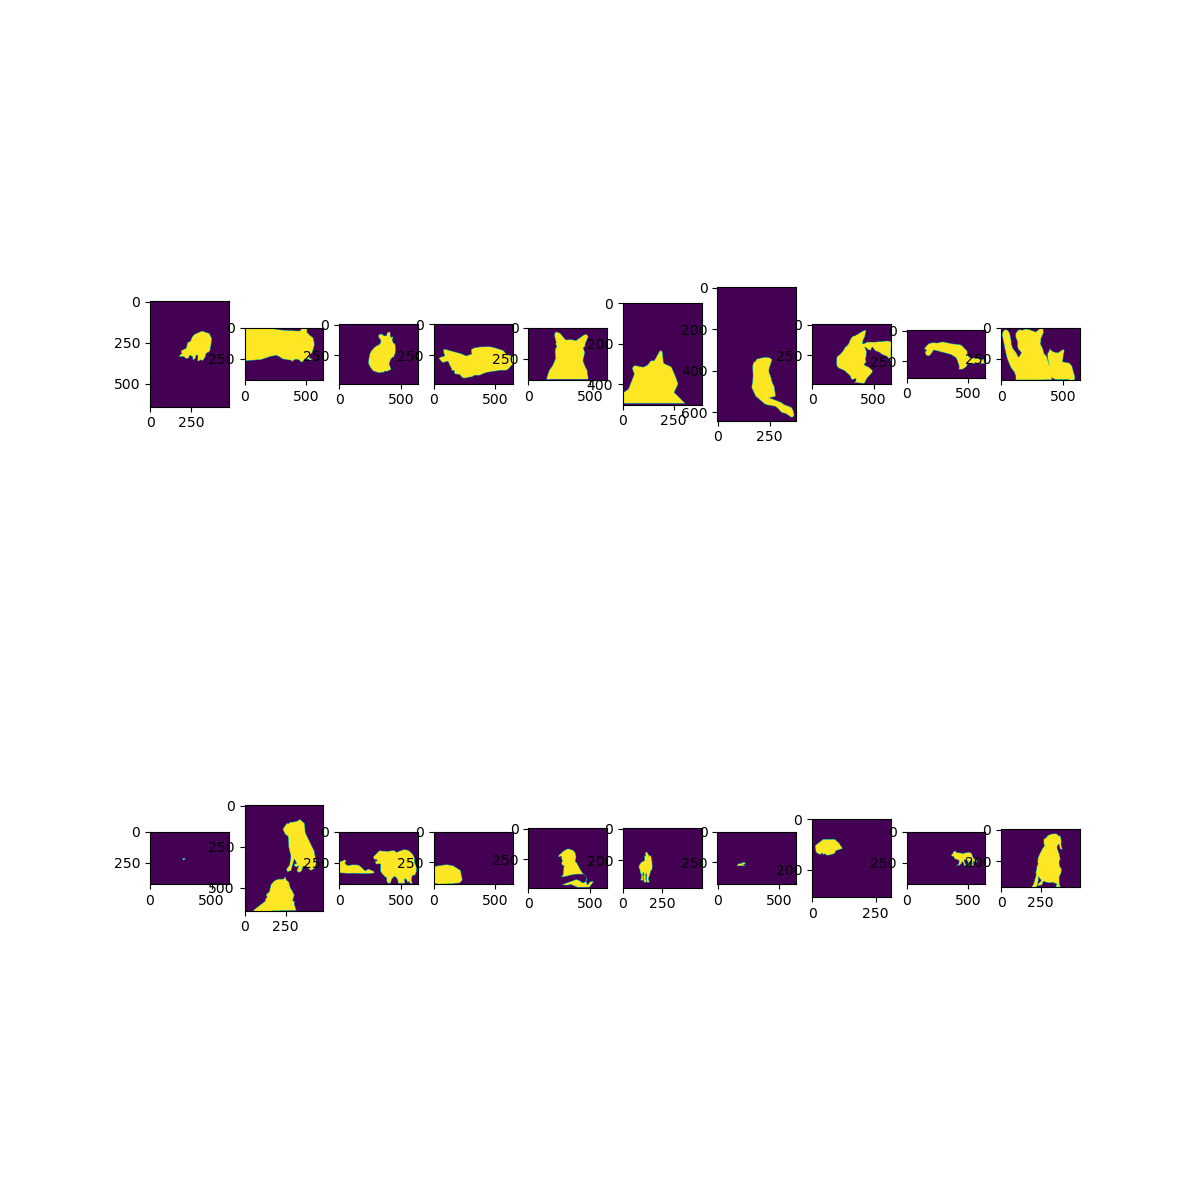

In [33]:
fig, axs = plt.subplots(2,10, figsize=(12,12))

i = 0
for animal, image_ids in animal_no_intersections.items():
    for j in range(10):
        # img = coco.loadImgs(image_ids[j])[0]
        annotation_ids = coco_train.getAnnIds(imgIds=image_ids[j], catIds=animal, iscrowd=False)
        annotations = coco_train.loadAnns(annotation_ids)
        # print(annotations)
        mask = np.zeros(coco_train.annToMask(annotations[0]).shape)
        for annotation in annotations:
            # print(annotation)
            if annotation['category_id'] == animal:
                masks = coco_train.annToMask(annotation)
                # print(masks)
                mask += masks
        mask[mask!=0] = 1
        axs[i,j].imshow(mask)
    i += 1
plt.show()

{'license': 1, 'file_name': '000000286720.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000286720.jpg', 'height': 640, 'width': 480, 'date_captured': '2013-11-15 05:35:24', 'flickr_url': 'http://farm4.staticflickr.com/3386/3346836280_ac5303bd50_z.jpg', 'id': 286720}
<PIL.Image.Image image mode=RGB size=224x224 at 0x20E9E31D710>
{'license': 2, 'file_name': '000000073729.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000073729.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-18 00:35:46', 'flickr_url': 'http://farm1.staticflickr.com/130/321307778_7ac99d2f59_z.jpg', 'id': 73729}
<PIL.Image.Image image mode=RGB size=224x224 at 0x20EC83DD190>
{'license': 6, 'file_name': '000000417802.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000417802.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-18 00:13:54', 'flickr_url': 'http://farm3.staticflickr.com/2150/2315944388_e2e1755ee3_z.jpg', 'id': 417802}
<PIL.Image.Image image mode=

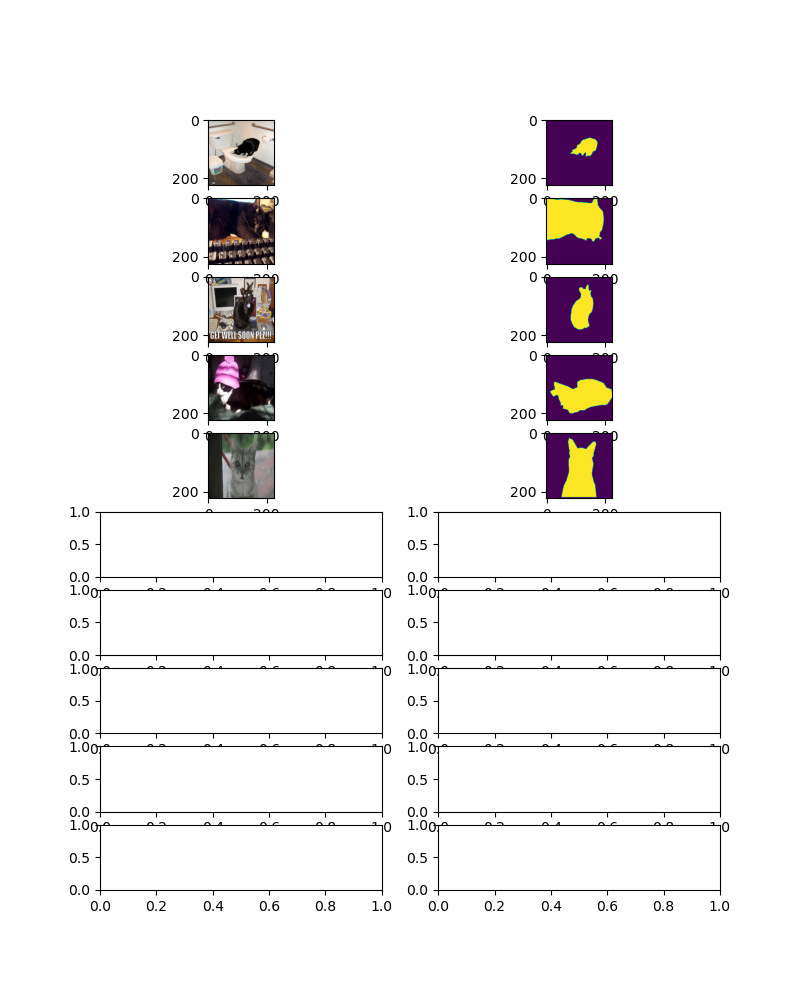

In [34]:
%matplotlib ipympl
from PIL import Image

fig, axs = plt.subplots(10,2)

animal = 17
image_ids = animal_no_intersections[animal]
# j = 1

for j in range(5):
    img = coco_train.loadImgs(image_ids[j])[0]
    print(img)
    
    with Image.open(f'./coco/train2017/{img["file_name"]}') as im:
        I = im.resize((224,224))
    print(I)
    # I = io.imread()
    # print(img['coco_url'])
    # print(I)
    
    annotation_ids = coco_train.getAnnIds(imgIds=image_ids[j], catIds=animal, iscrowd=False)
    annotations = coco_train.loadAnns(annotation_ids)
    
    mask = np.zeros(coco_train.annToMask(annotations[0]).shape)
    for annotation in annotations:
        # print(annotation)
        if annotation['category_id'] == animal:
            masks = coco_train.annToMask(annotation)
            # print(masks)
            mask += masks
    mask[mask!=0] = 1
    
    mask_im = Image.fromarray(np.uint8(mask)).convert('RGB').resize((224,224))
    
    axs[j,0].imshow(I)
    axs[j,1].imshow(np.array(mask_im)[:,:,0])

plt.show()
# axs[1,0].imshow(I.resize((224,224)))

In [35]:
import cv2


In [36]:
mask = coco_train.annToMask(annotations[0])

In [37]:
def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/histogram-equalization-with-python-and.html
    # https://en.wikipedia.org/wiki/Histogram_equalization
    # https://stackoverflow.com/a/28520445
    
    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = (number_bins-1) * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf

In [38]:
img

{'license': 4,
 'file_name': '000000532491.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000532491.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-15 19:25:10',
 'flickr_url': 'http://farm5.staticflickr.com/4144/5010032208_663a7e9665_z.jpg',
 'id': 532491}

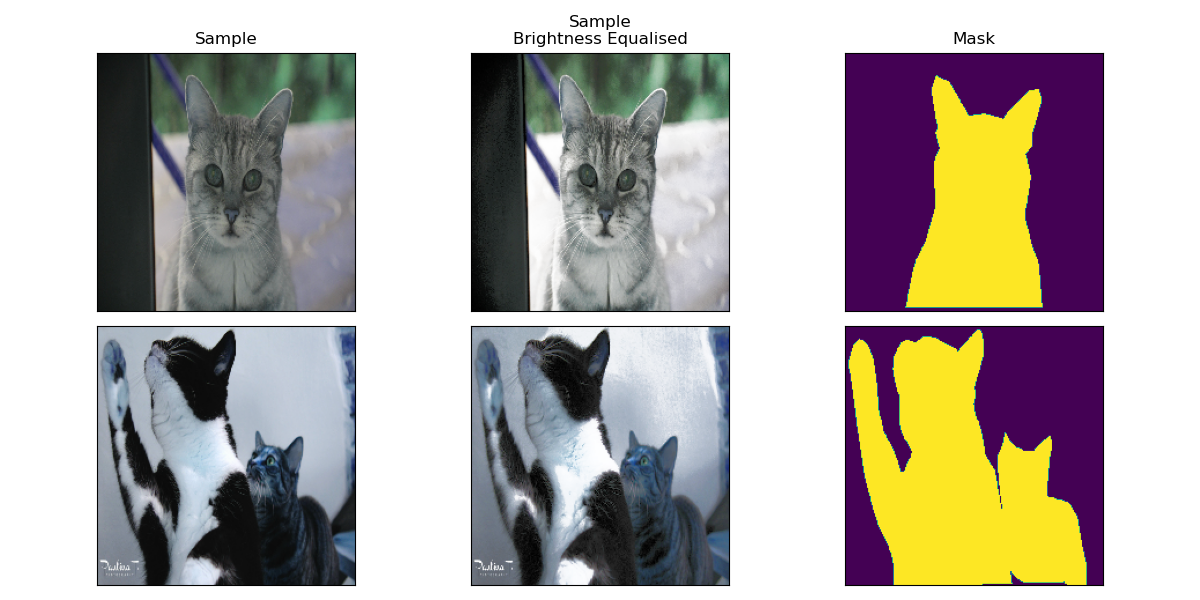

In [39]:
%matplotlib ipympl
fig, axs = plt.subplots(2,3, figsize=(12,6), tight_layout=True)

for j, img_id in enumerate([4,9]):
    img = coco_train.loadImgs(image_ids[img_id])[0]
    I = cv2.imread(f'./coco/train2017/{img["file_name"]}', cv2.IMREAD_COLOR)
    out = cv2.cvtColor(   I, cv2.COLOR_RGB2HLS ) / 255 # a bitmap conversion
    
    
    I = cv2.resize(cv2.imread(f'./coco/train2017/{img["file_name"]}', cv2.IMREAD_COLOR), (224,224))
    out_norm = np.asarray(cv2.cvtColor(   I, cv2.COLOR_RGB2HLS ))  # a bitmap conversion 
    
    out_norm[:,:,1] = image_histogram_equalization(out_norm[:,:,1])[0]
    # print(out_norm[:,:,1])
    
    axs[j,0].imshow(I)
    axs[j,1].imshow(cv2.cvtColor(   out_norm, cv2.COLOR_HLS2RGB ))
    
    
    annotation_ids = coco_train.getAnnIds(imgIds=img['id'], catIds=animal, iscrowd=False)
    annotations = coco_train.loadAnns(annotation_ids)
    
    mask = np.zeros(coco_train.annToMask(annotations[0]).shape)
    for annotation in annotations:
        # print(annotation)
        if annotation['category_id'] == animal:
            masks = coco_train.annToMask(annotation)
            # print(masks)
            mask += masks
    mask[mask!=0] = 1
    
    mask_im = Image.fromarray(np.uint8(mask)).convert('RGB').resize((224,224))
    
    axs[j,2].imshow(np.array(mask_im)[:,:,0])
    # axs[1,1].imshow(out_norm[:,:,1], cmap='Grays')
    
    out_norm = out_norm / 255

    for i in range(3):
        axs[j,i].set_xticks([])
        axs[j,i].set_yticks([])


axs[0,0].set_title('Sample')
axs[0,1].set_title('Sample\nBrightness Equalised')
axs[0,2].set_title('Mask')

plt.show()

# for i, scalar in enumerate([0.75,0.5,0.25]):
#     out_copy = np.asarray(out).copy()
#     out_copy[:,:,1] = scalar * out_copy[:,:,1]

#     out_norm_copy = out_norm.copy()
#     out_norm_copy[:,:,1] = scalar * out_norm_copy[:,:,1]

#     print(out_norm_copy[:,:,1].min())
#     print(out_norm_copy[:,:,1].max())
    
#     axs[0,i+2].imshow(scalar*out_copy, cmap='Grays', vmin=0, vmax=255)

#     # out_norm = np.asarray(cv2.cvtColor(   I, cv2.COLOR_RGB2HLS )) # a bitmap conversion
#     # out_norm[:,:,1] = image_histogram_equalization(out_norm[:,:,1])[0]
    
#     axs[1,i+2].imshow(scalar*out_norm_copy, cmap='Grays', vmin=0, vmax=255)

In [40]:
# import sys
# sys.exit(0)

In [41]:
# for key, value in animal_no_intersections_val.items():
#     animal_no_intersections[key].extend(value)

In [43]:
n = 7000
n_per_class = 3500

data = np.zeros((n, 224,224,3))
data_not_norm = np.zeros((n, 224,224,3))
data_sigmoid = np.zeros((n, 224,224,3))

labels = np.zeros((n,))
masks = np.zeros((n, 224,224))

j = 0
for i, (key, value) in enumerate(animal_no_intersections.items()):
    if len(value) >= n_per_class:
        print(i, key, len(value))

        for id in value[:n_per_class]:
            img = coco_train.loadImgs(id)[0]
    
            I = cv2.resize(cv2.imread(f'./coco/train2017/{img["file_name"]}', cv2.IMREAD_COLOR), (224,224))

            out_norm = np.asarray(cv2.cvtColor(   I, cv2.COLOR_RGB2HLS ))  # a bitmap conversion 
            data_not_norm[j] = out_norm.copy() / 255

            norm_sigmoid = out_norm.copy() / 255
            norm_sigmoid[:,:,1] =  1 / (1 + np.exp(-0.5*norm_sigmoid[:,:,1]  - 0.25)) 
            
            data_sigmoid[j] = norm_sigmoid
            
            out_norm[:,:,1] = image_histogram_equalization(out_norm[:,:,1])[0]
            out_norm = out_norm / 255
            
            annotation_ids = coco_train.getAnnIds(imgIds=id, catIds=key, iscrowd=False)
            annotations = coco_train.loadAnns(annotation_ids)
            
            mask = np.zeros(coco_train.annToMask(annotations[0]).shape)
            for annotation in annotations:
                # print(annotation)
                if annotation['category_id'] == key:
                    masks_animal = coco_train.annToMask(annotation)
                    # print(masks)
                    mask += masks_animal
            mask[mask!=0] = 1

            mask_im = Image.fromarray(np.uint8(mask)).convert('RGB').resize((224,224))
            
            data[j] = out_norm
            labels[j] = i
            masks[j] = np.asarray(mask_im)[:,:,0]
            
            j+=1

MemoryError: Unable to allocate 7.85 GiB for an array with shape (7000, 224, 224, 3) and data type float64

In [ ]:
# fig,axs = plt.subplots(1,1)
# axs.hist(data_not_norm[:,:,:,1].flatten(), bins=256) 
# axs.set_title("lightness distribution histogram")

# # axs[1].hist(data[:,:,:,1].flatten(), bins=256) 
# # axs[1].set_title("histogram equalised distribution")

# # axs[2].hist(data_sigmoid[:,:,:,1].flatten(), bins=256) 
# # axs[2].set_title("sigmoid equalised distribution")

# plt.show()

In [ ]:
# import seaborn as sns

# mean = 0.5
# sigma = 0.2


# data = np.random.normal(size=(224*244), loc=mean, scale=sigma)
# data_lim = data[np.where(np.logical_and(data >= 0, data <= 1))]

# data_lim_19 = data[np.where(np.logical_and(data >= 0.1, data <= 0.9))]

# data_lim_28 = data[np.where(np.logical_and(data >= 0.2, data <= 0.8))]

# # pdf = stats.norm.pdf(data_lim,loc=mu,scale=sigma)


# fig, axs = plt.subplots(3,1)
# # axs[0].hist(data_lim, range=(0,1), density=True)
# # axs[0].plot(data_lim, pdf, color='r')


# sns.histplot(data_lim, kde=True, ax=axs[0])
# sns.histplot(data_lim_19, kde=True, ax=axs[1])
# sns.histplot(data_lim_28, kde=True, ax=axs[2])
# plt.show()

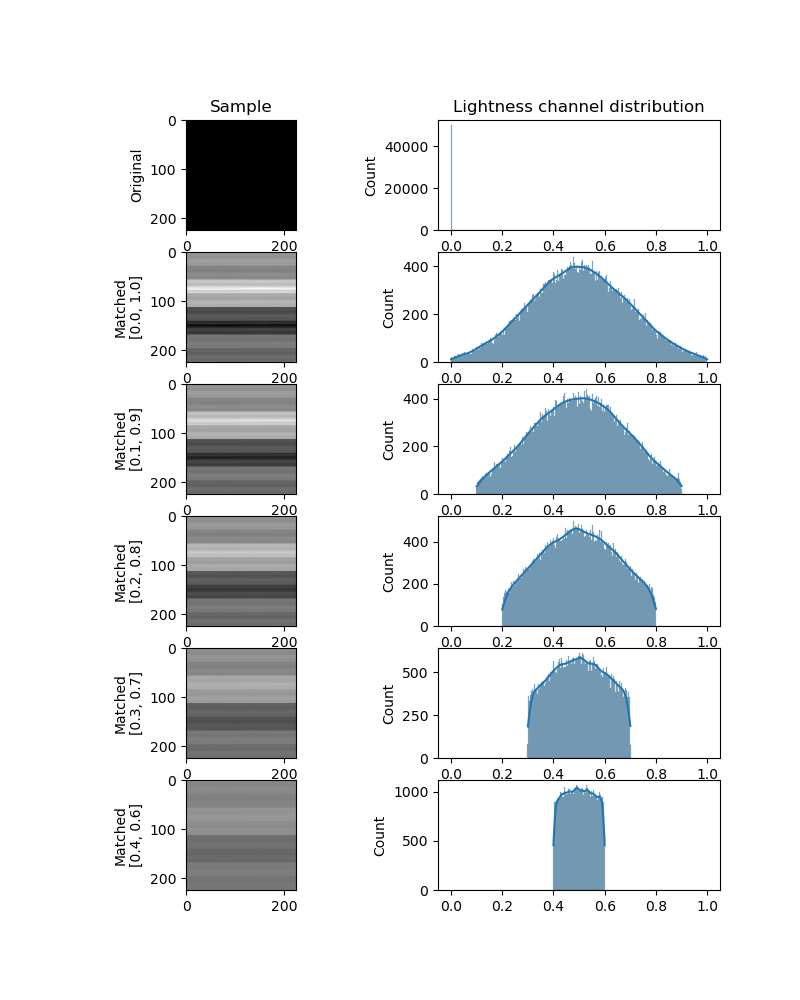

In [44]:
# https://github.com/nbottenus/histogram_matching
from skimage.exposure import match_histograms
import scipy.stats
import seaborn as sns

# lower = 0
# upper = 1

mu = 0.5
sigma = 0.2
N = 224*224

data_ind = 4

fig,axs = plt.subplots(6,2)


axs[0,0].imshow(cv2.cvtColor( (data_not_norm[data_ind]*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))
sns.histplot(data_not_norm[data_ind][:,:,1].reshape((224*
                                                     224,)), kde=True, binrange=(0,1), ax=axs[0,1], bins=256)

axs[0,0].set_title('Sample')
axs[0,1].set_title('Lightness channel distribution')

axs[0,0].set_ylabel('Original')

for i, bounds in enumerate([[0.0,1.0],[0.1,0.9],[0.2,0.8],[0.3,0.7], [0.4,0.6]]):
    lower = bounds[0]
    upper = bounds[1]

    ref = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)    

    sorted = data_not_norm[data_ind][:,:,1].copy().reshape((224*224,))

    ref_sorted = ref.copy()
    ref_sorted = ref_sorted[np.argsort(ref)]
    
    sorted[np.argsort(sorted)] = ref_sorted

    copied = data_not_norm[data_ind].copy()
    copied[:,:,1] = sorted.reshape((224,224))

    axs[i+1,0].imshow(cv2.cvtColor( (copied*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))
    sns.histplot(ref, kde=True, binrange=(0,1), ax=axs[i+1,1], bins=256)

    axs[i+1,0].set_ylabel(f'Matched\n{bounds}')

In [ ]:
fig, axs = plt.subplots(1,3)


lower = 0
upper = 1
mu = 0.5
sigma = 0.2
N = 224*224
ref = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)  


sns.histplot(data_not_norm[0][:,:,1].reshape((224*224,)), kde=True, binrange=(0,1), ax=axs[0], bins=256)
sns.histplot(ref, kde=True, binrange=(0,1), ax=axs[1], bins=256)

sorted = data_not_norm[0][:,:,1].copy().reshape((224*224,))

ref_sorted = ref.copy()
ref_sorted = ref_sorted[np.argsort(ref)]

sorted[np.argsort(sorted)] = ref_sorted

sns.histplot(sorted, kde=True, binrange=(0,1), ax=axs[2], bins=256)

In [ ]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(cv2.cvtColor( (data_not_norm[0]*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))


copied = data_not_norm[0].copy()
copied[:,:,1] = sorted.reshape((224,224))

axs[0,1].imshow(cv2.cvtColor( (copied*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

axs[1,0].imshow(data_not_norm[0])
axs[1,1].imshow(copied)

In [ ]:
copied == data_not_norm[1]

In [ ]:
data_not_norm[1]

In [ ]:
from skimage.exposure import match_histograms
import scipy.stats
lower = 0
upper = 1
mu = 0.5
sigma = 0.2
N = 224*224

norm = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)

# norm = np.random.normal(loc=0.5,scale=0.1, size=(224*244,))

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(cv2.cvtColor( (data_not_norm[0]*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))
axs[1,0].hist(data_not_norm[0][:,:,1].flatten(), bins=256) 


matched = data_not_norm[0].copy()
matched_flatten = match_histograms(matched[:,:,1].flatten(), norm.flatten())
matched[:,:,1] = matched_flatten.reshape((224,224))

axs[1,1].hist(matched[:,:,1].flatten(), bins=256)
axs[0,1].imshow(cv2.cvtColor( (matched*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))
plt.show()

In [60]:
I

array([[[  2,  11,  26],
        [  1,   9,  26],
        [  3,  10,  29],
        ...,
        [ 79,  74,  85],
        [ 61,  53,  57],
        [ 63,  59,  63]],

       [[  4,  12,  29],
        [  3,  11,  28],
        [  2,   9,  28],
        ...,
        [ 93,  87, 100],
        [ 74,  63,  73],
        [ 69,  61,  71]],

       [[  5,  13,  30],
        [  3,  11,  29],
        [  3,  10,  30],
        ...,
        [ 93,  84,  99],
        [ 91,  81,  92],
        [ 63,  53,  63]],

       ...,

       [[  0,   6,  12],
        [  2,   7,  16],
        [  1,   8,  11],
        ...,
        [118, 119, 133],
        [113, 116, 131],
        [108, 112, 126]],

       [[  1,   7,  13],
        [  2,   7,  16],
        [  0,   7,  10],
        ...,
        [113, 116, 130],
        [110, 115, 130],
        [108, 114, 128]],

       [[  1,   7,  13],
        [  2,   7,  16],
        [  0,   5,   9],
        ...,
        [104, 108, 125],
        [101, 107, 124],
        [ 97, 103, 121]]

In [66]:
I[:,0]

array([[  2,  11,  26],
       [  4,  12,  29],
       [  5,  13,  30],
       [  5,  12,  31],
       [  5,  12,  31],
       [  4,  11,  31],
       [  3,  12,  33],
       [  2,  13,  35],
       [  3,  10,  33],
       [  6,  12,  34],
       [  5,  11,  33],
       [  3,  11,  35],
       [  4,  14,  38],
       [  3,  13,  38],
       [  5,  13,  38],
       [  6,  16,  39],
       [  3,  16,  38],
       [  2,  14,  40],
       [  4,  15,  44],
       [ 10,  20,  48],
       [  2,  15,  41],
       [  2,  15,  41],
       [  5,  17,  44],
       [  3,  15,  43],
       [  3,  16,  49],
       [  2,  15,  47],
       [  4,  18,  47],
       [  3,  15,  49],
       [  6,  18,  53],
       [  3,  19,  57],
       [  4,  18,  55],
       [  4,  17,  50],
       [  5,  18,  47],
       [  3,  17,  47],
       [  3,  17,  49],
       [  2,  16,  50],
       [  1,  19,  55],
       [  4,  21,  63],
       [  3,  19,  62],
       [  1,  21,  60],
       [  2,  22,  58],
       [  4,  20

25567.529411764703
16914.476785732448
25162.228297191676
33526.8292938532


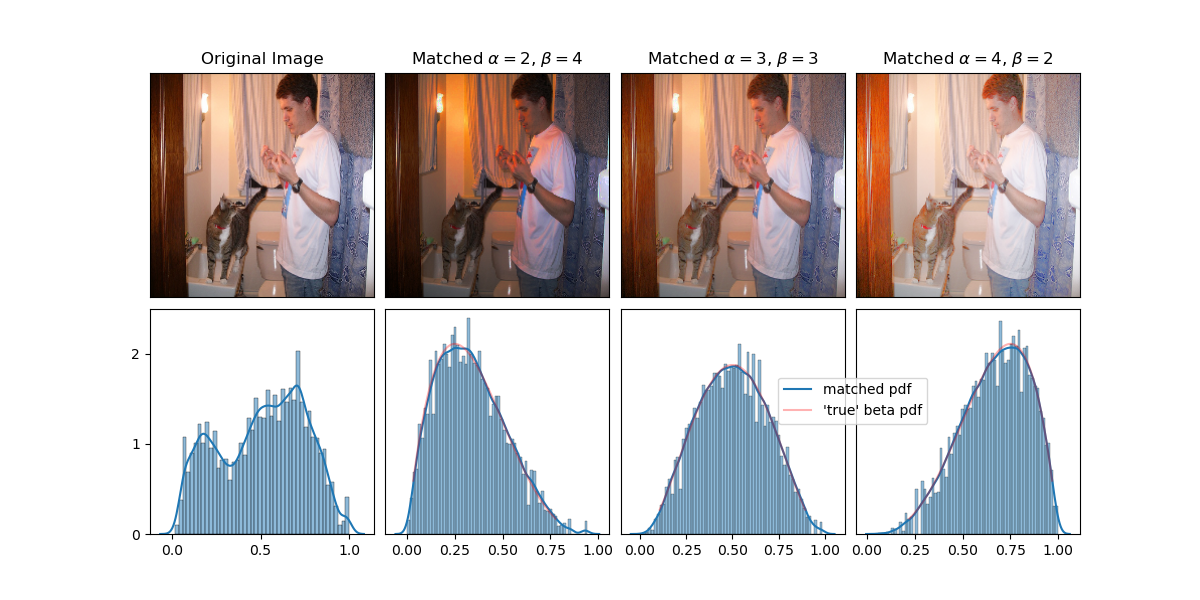

In [56]:
from skimage.exposure import match_histograms
import seaborn as sns
import scipy.stats
lower = 0
upper = 1
mu = 0.5
sigma = 0.2
N = 224*224

# norm = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
beta_dark = scipy.stats.beta.rvs(2, 4, size=N)
beta_light = scipy.stats.beta.rvs(4, 2, size=N)
beta_norm = scipy.stats.beta.rvs(3,3, size=N)


img = coco_train.loadImgs(animal_no_intersections[17][11])[0]

I = cv2.resize(cv2.imread(f'./coco/train2017/{img["file_name"]}', cv2.IMREAD_COLOR), (224,224))

out_norm = np.asarray(cv2.cvtColor(   I, cv2.COLOR_BGR2HLS ))  # a bitmap conversion 
data_not_norm = out_norm.copy() / 255

# norm = np.random.normal(loc=0.5,scale=0.1, size=(224*244,))

fig, axs = plt.subplots(2,4, figsize=(12,6))
axs[0,0].imshow(cv2.cvtColor( (data_not_norm*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))
# axs[1,0].hist(data_not_norm[0][:,:,1].flatten(), bins=256) 

print(np.sum(data_not_norm[:,:,1]))

sns.histplot(data_not_norm[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,0])


matched = data_not_norm.copy()
matched_flatten = match_histograms(matched[:,:,1].flatten(), beta_dark.flatten())
matched[:,:,1] = matched_flatten.reshape((224,224))

axs[0,1].imshow(cv2.cvtColor( (matched*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

print(np.sum(matched[:,:,1]))

a, b = 2,4
# mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

sns.histplot(matched[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,1])
axs[1,1].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

axs[0,1].set_title(r'Matched $\alpha = $' + str(a) + r', $\beta = $' + str(b))

##################################


matched_norm = data_not_norm.copy()
matched_flatten_norm = match_histograms(matched_norm[:,:,1].flatten(), beta_norm.flatten())
matched_norm[:,:,1] = matched_flatten_norm.reshape((224,224))

# axs[1,2].hist(matched_light[:,:,1].flatten(), bins=256)
axs[0,2].imshow(cv2.cvtColor( (matched_norm*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

print(np.sum(matched_norm[:,:,1]))

a, b = 3,3 
# mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

line1 = sns.histplot(matched_norm[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,2])
pdf = axs[1,2].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

axs[0,2].set_title(r'Matched $\alpha = $' + str(a) + r', $\beta = $' + str(b))
##################################



matched_light = data_not_norm.copy()
matched_flatten_light = match_histograms(matched_light[:,:,1].flatten(), beta_light.flatten())
matched_light[:,:,1] = matched_flatten_light.reshape((224,224))

# axs[1,2].hist(matched_light[:,:,1].flatten(), bins=256)
axs[0,3].imshow(cv2.cvtColor( (matched_light*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

print(np.sum(matched_light[:,:,1]))

a, b = 4,2
# mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

line1 = sns.histplot(matched_light[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,3])
pdf = axs[1,3].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

axs[0,3].set_title(r'Matched $\alpha = $' + str(a) + r', $\beta = $' + str(b))

axs[0,0].set_title('Original Image')
# axs[0,1].set_title(f'Matched $\alpha = {a}, \beta = 5$')
# axs[0,2].set_title(f'Matched $\alpha = 2, \beta = 2$')
# axs[0,3].set_title(f'Matched $\alpha = 5, \beta = 2$')

# labels = fig.get_labels()

for j in range(4):
    axs[0,j].set_xticks([])
    axs[0,j].set_yticks([])

    axs[1,j].set_ylabel('')
    axs[1,j].set_ylim(0,2.5)

    if j > 0:
        axs[1,j].set_yticks([])

axs[1,0].set_yticks([0, 1.0, 2.0])

axs[1,3].legend([line1.get_lines()[0], pdf[0]], ['matched pdf', "'true' beta pdf"], bbox_to_anchor=(0.35,0.725))

plt.subplots_adjust(wspace=0.05, hspace=0.05)
# plt.savefig('./figures/coco/data_histograms.png', bbox_inches='tight')

In [ ]:
animal_no_intersections.keys()

In [ ]:
from skimage.exposure import match_histograms
import scipy.stats
lower = 0
upper = 1
mu = 0.5
sigma = 0.2
N = 224*224

# norm = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
beta_dark = scipy.stats.beta.rvs(2, 4, size=N)
beta_light = scipy.stats.beta.rvs(4, 2, size=N)
beta_norm = scipy.stats.beta.rvs(3, 3, size=N)


img_cat_1 = coco_train.loadImgs(animal_no_intersections[17][2])[0]
img_cat_2 = coco_train.loadImgs(animal_no_intersections[17][0])[0]

img_dog_1 = coco_train.loadImgs(animal_no_intersections[18][2])[0]
img_dog_2 = coco_train.loadImgs(animal_no_intersections[18][1])[0]

I_c1 = cv2.resize(cv2.imread(f'./coco/train2017/{img_cat_1["file_name"]}', cv2.IMREAD_COLOR), (224,224))
I_c2 = cv2.resize(cv2.imread(f'./coco/train2017/{img_cat_2["file_name"]}', cv2.IMREAD_COLOR), (224,224))

I_d1 = cv2.resize(cv2.imread(f'./coco/train2017/{img_dog_1["file_name"]}', cv2.IMREAD_COLOR), (224,224))
I_d2 = cv2.resize(cv2.imread(f'./coco/train2017/{img_dog_2["file_name"]}', cv2.IMREAD_COLOR), (224,224))

out_norm_c1 = np.asarray(cv2.cvtColor(   I_c1, cv2.COLOR_BGR2HLS ))  # a bitmap conversion 
data_not_norm_c1 = out_norm_c1.copy() / 255

out_norm_c2 = np.asarray(cv2.cvtColor(   I_c2, cv2.COLOR_BGR2HLS ))  # a bitmap conversion 
data_not_norm_c2 = out_norm_c2.copy() / 255

out_norm_d1 = np.asarray(cv2.cvtColor(   I_d1, cv2.COLOR_BGR2HLS ))  # a bitmap conversion 
data_not_norm_d1 = out_norm_d1.copy() / 255

out_norm_d2 = np.asarray(cv2.cvtColor(   I_d2, cv2.COLOR_BGR2HLS ))  # a bitmap conversion 
data_not_norm_d2 = out_norm_d2.copy() / 255


In [ ]:
img_cat_1

In [ ]:
from skimage.exposure import match_histograms
import scipy.stats

fig, axs = plt.subplots(1,2)

# beta_dark = scipy.stats.beta.rvs(2, 5, size=N)
# beta_light = scipy.stats.beta.rvs(5, 2, size=N)

img_cat_1 = coco_train.loadImgs(animal_no_intersections[17][2])[0]
I_c1 = cv2.resize(cv2.imread(f'./coco/train2017/{img_cat_1["file_name"]}'), (224,224))

# out_norm_c1 = np.asarray(cv2.cvtColor(   I_c1, cv2.COLOR_RGB2HLS ))  # a bitmap conversion 
# data_not_norm_c1 = out_norm_c1.copy() / 255

axs[0].imshow(I_c1)
axs[1].imshow(cv2.cvtColor(I_c1  , cv2.COLOR_BGR2RGB ))

In [ ]:
# Plot 1: Confounder
# | cat_1_dark | cat_2_dark | dog_1_light | dog_2_light
# 

In [ ]:
fig, axs = plt.subplots(2,4, figsize=(12,6))

matched = data_not_norm_c1.copy()
matched_flatten = match_histograms(matched[:,:,1].flatten(), beta_dark.flatten())
matched[:,:,1] = matched_flatten.reshape((224,224))

axs[0,0].imshow(cv2.cvtColor( (matched*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))
# axs[1,0].hist(data_not_norm[0][:,:,1].flatten(), bins=256) 


a, b = 2, 4
# mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

sns.histplot(matched[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,0])
axs[1,0].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

matched = data_not_norm_c2.copy()
matched_flatten = match_histograms(matched[:,:,1].flatten(), beta_dark.flatten())
matched[:,:,1] = matched_flatten.reshape((224,224))

axs[0,1].imshow(cv2.cvtColor( (matched*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

a, b = 2, 4
# mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

sns.histplot(matched[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,1])
axs[1,1].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

# axs[0,1].set_title(r'Matched $\alpha = $' + str(a) + r', $\beta = $' + str(b))

##################################


matched_norm = data_not_norm_d1.copy()
matched_flatten_norm = match_histograms(matched_norm[:,:,1].flatten(), beta_light.flatten())
matched_norm[:,:,1] = matched_flatten_norm.reshape((224,224))

# axs[1,2].hist(matched_light[:,:,1].flatten(), bins=256)
axs[0,2].imshow(cv2.cvtColor( (matched_norm*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

a, b = 4, 2
# mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

line1 = sns.histplot(matched_norm[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,2])
pdf = axs[1,2].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

# axs[0,2].set_title(r'Matched $\alpha = $' + str(a) + r', $\beta = $' + str(b))
##################################



matched_light = data_not_norm_d2.copy()
matched_flatten_light = match_histograms(matched_light[:,:,1].flatten(), beta_light.flatten())
matched_light[:,:,1] = matched_flatten_light.reshape((224,224))

# axs[1,2].hist(matched_light[:,:,1].flatten(), bins=256)
axs[0,3].imshow(cv2.cvtColor( (matched_light*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

a, b = 4, 2
# mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

line1 = sns.histplot(matched_light[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,3])
pdf = axs[1,3].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

# axs[0,3].set_title(r'Matched $\alpha = $' + str(a) + r', $\beta = $' + str(b))

# axs[0,0].set_title('Original Image')
# axs[0,1].set_title(f'Matched $\alpha = {a}, \beta = 5$')
# axs[0,2].set_title(f'Matched $\alpha = 2, \beta = 2$')
# axs[0,3].set_title(f'Matched $\alpha = 5, \beta = 2$')

# labels = fig.get_labels()

for j in range(4):
    axs[0,j].set_xticks([])
    axs[0,j].set_yticks([])

    axs[1,j].set_ylabel('')
    axs[1,j].set_ylim(0,3)

    if j > 0:
        axs[1,j].set_yticks([])

axs[1,0].set_yticks([0, 1.0, 2.0])

axs[1,3].legend([line1.get_lines()[0], pdf[0]], ['matched pdf', "'true' beta pdf"], bbox_to_anchor=(0.5,0.75))

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig('./figures/coco/data_histograms_confounder.png', bbox_inches='tight')

In [ ]:
# plot: suppressor 1

In [ ]:
fig, axs = plt.subplots(2,4, figsize=(12,6))

matched = data_not_norm_c1.copy()
matched_flatten = match_histograms(matched[:,:,1].flatten(), beta_dark.flatten())
matched[:,:,1] = matched_flatten.reshape((224,224))

axs[0,0].imshow(cv2.cvtColor( (matched*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))
# axs[1,0].hist(data_not_norm[0][:,:,1].flatten(), bins=256) 


a, b = 2, 5
# mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

sns.histplot(matched[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,0])
axs[1,0].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

##################################

matched = data_not_norm_c2.copy()
matched_flatten = match_histograms(matched[:,:,1].flatten(), beta_light.flatten())
matched[:,:,1] = matched_flatten.reshape((224,224))

axs[0,1].imshow(cv2.cvtColor( (matched*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

a, b = 5, 2
# mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

sns.histplot(matched[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,1])
axs[1,1].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

# axs[0,1].set_title(r'Matched $\alpha = $' + str(a) + r', $\beta = $' + str(b))

##################################


matched_norm = data_not_norm_d1.copy()
matched_flatten_norm = match_histograms(matched_norm[:,:,1].flatten(), beta_dark.flatten())
matched_norm[:,:,1] = matched_flatten_norm.reshape((224,224))

# axs[1,2].hist(matched_light[:,:,1].flatten(), bins=256)
axs[0,2].imshow(cv2.cvtColor( (matched_norm*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

a, b = 2, 5
# mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

line1 = sns.histplot(matched_norm[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,2])
pdf = axs[1,2].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

# axs[0,2].set_title(r'Matched $\alpha = $' + str(a) + r', $\beta = $' + str(b))
##################################



matched_light = data_not_norm_d2.copy()
matched_flatten_light = match_histograms(matched_light[:,:,1].flatten(), beta_light.flatten())
matched_light[:,:,1] = matched_flatten_light.reshape((224,224))

# axs[1,2].hist(matched_light[:,:,1].flatten(), bins=256)
axs[0,3].imshow(cv2.cvtColor( (matched_light*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

a, b = 5, 2
# mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

line1 = sns.histplot(matched_light[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,3])
pdf = axs[1,3].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

# axs[0,3].set_title(r'Matched $\alpha = $' + str(a) + r', $\beta = $' + str(b))

# axs[0,0].set_title('Original Image')
# axs[0,1].set_title(f'Matched $\alpha = {a}, \beta = 5$')
# axs[0,2].set_title(f'Matched $\alpha = 2, \beta = 2$')
# axs[0,3].set_title(f'Matched $\alpha = 5, \beta = 2$')

# labels = fig.get_labels()

for j in range(4):
    axs[0,j].set_xticks([])
    axs[0,j].set_yticks([])

    axs[1,j].set_ylabel('')
    axs[1,j].set_ylim(0,3)

    if j > 0:
        axs[1,j].set_yticks([])

axs[1,0].set_yticks([0, 1.0, 2.0])

axs[1,3].legend([line1.get_lines()[0], pdf[0]], ['matched pdf', "'true' beta pdf"], bbox_to_anchor=(0.5,0.75))

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig('./figures/coco/data_histograms_suppressor_1.png', bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(6,6))

matched = data_not_norm_c1.copy()
matched_flatten = match_histograms(matched[:,:,1].flatten(), beta_norm.flatten())
matched[:,:,1] = matched_flatten.reshape((224,224))

axs[0,0].imshow(cv2.cvtColor( (matched*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))
# axs[1,0].hist(data_not_norm[0][:,:,1].flatten(), bins=256) 


a, b = 3,3
# mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

sns.histplot(matched[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,0])
axs[1,0].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

##################################

matched = data_not_norm_d2.copy()
matched_flatten = match_histograms(matched[:,:,1].flatten(), beta_norm.flatten())
matched[:,:,1] = matched_flatten.reshape((224,224))

axs[0,1].imshow(cv2.cvtColor( (matched*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

a, b = 3,3
# mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
                scipy.stats.beta.ppf(0.99, a, b), 100)

sns.histplot(matched[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,1])
axs[1,1].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

# axs[0,1].set_title(r'Matched $\alpha = $' + str(a) + r', $\beta = $' + str(b))

##################################

for j in range(2):
    axs[0,j].set_xticks([])
    axs[0,j].set_yticks([])

    axs[1,j].set_ylabel('')
    axs[1,j].set_ylim(0,3)

    if j > 0:
        axs[1,j].set_yticks([])

axs[1,0].set_yticks([0, 1.0, 2.0])

axs[1,1].legend([line1.get_lines()[0], pdf[0]], ['matched pdf', "'true' beta pdf"], bbox_to_anchor=(0.3,0.85))

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig('./figures/coco/data_histograms_suppressor_2.png', bbox_inches='tight')

In [ ]:
# from skimage.exposure import match_histograms
# import scipy.stats
# lower = 0
# upper = 1
# mu = 0.5
# sigma = 0.2
# N = 224*224

# # norm = scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
# beta_dark = scipy.stats.beta.rvs(2, 2, size=N)
# beta_light = scipy.stats.beta.rvs(3, 3, size=N)
# beta_norm = scipy.stats.beta.rvs(5, 5, size=N)


# # norm = np.random.normal(loc=0.5,scale=0.1, size=(224*244,))


# img = coco_train.loadImgs(image_ids[3])[0]

# I = cv2.resize(cv2.imread(f'./coco/train2017/{img["file_name"]}', cv2.IMREAD_COLOR), (224,224))

# out_norm = np.asarray(cv2.cvtColor(   I, cv2.COLOR_RGB2HLS ))  # a bitmap conversion 
# data_not_norm = out_norm.copy() / 255

# print(data_not_norm.shape)

# fig, axs = plt.subplots(2,4, figsize=(12,6))
# axs[0,0].imshow(cv2.cvtColor( (data_not_norm*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))
# # axs[1,0].hist(data_not_norm[0][:,:,1].flatten(), bins=256) 

# sns.histplot(data_not_norm[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,0])


# matched = data_not_norm.copy()
# matched_flatten = match_histograms(matched[:,:,1].flatten(), beta_dark.flatten())
# matched[:,:,1] = matched_flatten.reshape((224,224))

# axs[0,1].imshow(cv2.cvtColor( (matched*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

# a, b = 2, 2
# # mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
# x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
#                 scipy.stats.beta.ppf(0.99, a, b), 100)

# sns.histplot(matched[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,1])
# axs[1,1].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

# ##################################


# matched_norm = data_not_norm.copy()
# matched_flatten_norm = match_histograms(matched_norm[:,:,1].flatten(), beta_norm.flatten())
# matched_norm[:,:,1] = matched_flatten_norm.reshape((224,224))

# # axs[1,2].hist(matched_light[:,:,1].flatten(), bins=256)
# axs[0,2].imshow(cv2.cvtColor( (matched_norm*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

# a, b = 3, 3
# # mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
# x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
#                 scipy.stats.beta.ppf(0.99, a, b), 100)

# line1 = sns.histplot(matched_norm[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,2])
# pdf = axs[1,2].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)

# ##################################



# matched_light = data_not_norm.copy()
# matched_flatten_light = match_histograms(matched_light[:,:,1].flatten(), beta_light.flatten())
# matched_light[:,:,1] = matched_flatten_light.reshape((224,224))

# # axs[1,2].hist(matched_light[:,:,1].flatten(), bins=256)
# axs[0,3].imshow(cv2.cvtColor( (matched_light*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

# a, b = 5, 5
# # mean, var, skew, kurt = scipy.stats.beta(a, b, moments='mvsk')
# x = np.linspace(scipy.stats.beta.ppf(0.01, a, b),
#                 scipy.stats.beta.ppf(0.99, a, b), 100)

# line1 = sns.histplot(matched_light[:,:,1].flatten(), kde=True,stat="density", kde_kws=dict(cut=3), ax=axs[1,3])
# pdf = axs[1,3].plot(x, scipy.stats.beta.pdf(x, a, b), color='r', alpha=0.3)


# for k in range(3):
#     axs[1,k].set_ylim(0,3.2)

# axs[0,0].set_title('Original Image')
# axs[0,1].set_title(r'Matched $\alpha = 2, \beta = 2$')
# axs[0,2].set_title(r'Matched $\alpha = 3, \beta = 3$')
# axs[0,3].set_title(r'Matched $\alpha = 5, \beta = 5$')

# # labels = fig.get_labels()

# axs[1,3].legend([line1.get_lines()[0], pdf[0]], ['matched pdf', "'true' beta pdf"])

In [ ]:
(beta_dark + beta_light).shape


In [ ]:
fig, axs = plt.subplots(1)

sns.histplot(beta_dark + beta_light, kde=True,stat="density", kde_kws=dict(cut=3), ax=axs)
# axs.plot(range(50176), )

In [ ]:
beta_dark = scipy.stats.beta.rvs(2, 5, size=N)
print(beta_dark.min())
print(beta_dark.max())

In [ ]:
print("DONE!!")

In [ ]:
data[:,:,:,1].flatten().shape

In [ ]:
# import matplotlib.pyplot as plt
# rng = np.random.RandomState(10)  # deterministic random data
# a = np.hstack((rng.normal(size=1000),
#                rng.normal(loc=5, scale=2, size=1000)))
fig,axs = plt.subplots(1)
axs.hist(data[:,:,:,1].flatten(), bins=256)  # arguments are passed to np.histogram
plt.title("Cats and Dogs lightness distribution histogram")

plt.show()

In [ ]:
import sys
sys.exit(0)

In [ ]:
# import pickle as pkl

# # with open('coco_data.pkl', 'wb') as f:
# #     pkl.dump(data, f)


# nine_inds = np.where(labels==9)[0]
# labels[nine_inds] = 4

# with open('coco_labels.pkl', 'wb') as f:
#     pkl.dump(labels, f)
    
# with open('coco_masks.pkl', 'wb') as f:
#     pkl.dump(masks, f)

In [ ]:
# Shuffled 60/20/20 split
# split 60/40 into train and val+test, then split val and test by half

data_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=SEED)
train_indices, val_indices = list(data_splitter.split(X=data, y=labels))[0]


x_train = data[train_indices]
y_train = labels[train_indices]
x_val_test = data[val_indices]
y_val_test = labels[val_indices]

data_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
val_indices, test_indices = list(data_splitter.split(X=x_val_test, y=y_val_test))[0]

x_val = x_val_test[val_indices]
y_val = y_val_test[val_indices]

x_test = x_val_test[test_indices]
y_test = y_val_test[test_indices]

In [ ]:
# import pickle as pkl
# split_dataset = [(x_train, y_train, masks[train_indices]), (x_val, y_val, masks[val_indices]), (x_test, y_test, masks[test_indices])]

# with open('coco_data_cats_and_dogs.pkl', 'wb') as f:
#     pkl.dump(split_dataset, f)

In [ ]:
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (112360x160 and 800x128)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5)
        
        self.maxPooling2=nn.MaxPool2d(kernel_size=2)
        self.maxPooling4_0=nn.MaxPool2d(kernel_size=4)
        self.maxPooling4_1=nn.MaxPool2d(kernel_size=4)
#         self.adPooling=nn.AdaptiveAvgPool1d(256)
        
        self.fc1=nn.Linear(in_features=4096,out_features=128)
        self.fc2=nn.Linear(in_features=128,out_features=64)
        self.out=nn.Linear(in_features=64,out_features=5)

    def forward(self,x):
        x=self.conv1(x)
        x=self.maxPooling4_0(x)
        x=F.relu(x)
        
        x=self.conv2(x)
        x=self.maxPooling4_1(x)
        x=F.relu(x)
        
        x=self.conv3(x)
        x=self.maxPooling2(x)
        x=F.relu(x)
        
        x=F.dropout(x)
        x=x.view(1,x.size()[0],-1) #stretch to 1d data
        #x=self.adPooling(x).squeeze()
        
        x=self.fc1(x)
        x=F.relu(x)
        
        x=self.fc2(x)
        x=F.relu(x)
        
        x=self.out(x)
        
        return x[0]

In [ ]:
def train(lr,epochs,train_loader,val_loader,name_model,momentum=0.9,weight_decay=1e-3,num_models=10):
    DEVICE='cpu'
    
    metric = AUROC(task='multiclass', num_classes=5) 
    softmax = nn.Softmax(dim=1)
    
    training_accuracy = Accuracy(task='multiclass', num_classes=5).to(DEVICE)
    val_accuracy = Accuracy(task='multiclass', num_classes=5).to(DEVICE)

    torch.manual_seed(SEED)

    trained_models = []
    training_logs = []

    for training_ind in range(num_models):
        cnn_conf=Net()
        cnn_conf.to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        
        # Anders et. al uses mainly AdaDelta but also SGD in one section
#         optimizer = optim.SGD(cnn_conf.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        optimizer = optim.Adadelta(cnn_conf.parameters(), lr=lr, weight_decay=weight_decay)


        loss_list_train=[]
        loss_list_val=[]
        acc_list_train=[]
        acc_list_val=[]
        

        min_loss = 100000000
    #     last_loss = 1000000000

        for epoch in range(epochs):  # loop over the dataset multiple times
            print(f' epoch {epoch+1} in {epochs}')
            t0=time.time()
            epoch_loss = 0.0
            epoch_loss_val= 0.0
            batch_acc=[]
            batch_acc_val=[]

            auroc_train=[]
            auroc_val=[]

            pred_train=[]
            pred_val=[]
            true_labels_train=[]
            true_labels_val=[]

            for i, batch in enumerate(train_loader):
                inputs, labels = batch

                inputs = inputs.to(DEVICE,dtype=torch.float)
                labels = labels.type(torch.LongTensor)
                labels=labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = cnn_conf(inputs).squeeze()
                _, predicted = torch.max(outputs.data,1)

                # print(outputs.shape)
                # print(labels.shape)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()        
                batch_acc.append(training_accuracy(predicted, labels).item())

#                 print(softmax(outputs)[:,1].detach().numpy().shape)
#                 pred_train=np.concatenate((pred_train, softmax(outputs)[:,1].detach().numpy()))
#                 true_labels_train=np.concatenate((true_labels_train, labels.cpu().numpy()))
                
                auroc_train.append(metric(outputs,labels.to(torch.int32)))

            auroc_train = sum(auroc_train)/len(auroc_train)

            for i_v, data_val in enumerate(val_loader):
                inputs_val, labels_val = data_val

                inputs_val = inputs_val.to(DEVICE,dtype=torch.float)
                labels_val = labels_val.type(torch.LongTensor)
                labels_val=labels_val.to(DEVICE)

                outputs_val = cnn_conf(inputs_val).squeeze()
                _, predicted_val = torch.max(outputs_val.data, 1)

                loss_val = criterion(outputs_val, labels_val)

                epoch_loss_val += loss_val.item()        
                batch_acc_val.append(val_accuracy(predicted_val, labels_val).item())

                auroc_val.append(metric(outputs_val,labels_val.to(torch.int32)))

#                 pred_val=np.concatenate((pred_val, softmax(outputs_val)[:,1].cpu().detach().numpy()))
#                 true_labels_val=np.concatenate((true_labels_val, labels_val.cpu().detach().numpy()))
            auroc_val = sum(auroc_val)/len(auroc_val)

            if epoch_loss_val < min_loss:
                min_loss = epoch_loss_val
                save_model = type(cnn_conf)() # get a new instance
                save_model.load_state_dict(cnn_conf.state_dict()) # copy weights and stuff

                torch.save(save_model.state_dict(), f'{str(name_model)}_{training_ind}.pt')

#             auroc_val=metric(torch.tensor(pred_val),torch.tensor(true_labels_val).to(torch.int32))

            epoch_acc=sum(batch_acc)/len(batch_acc)
            epoch_acc_val=sum(batch_acc_val)/len(batch_acc_val)

            print(f'epoch train loss: {epoch_loss} | epoch train acc {epoch_acc} | AUROC: {auroc_train}')
            print(f'epoch val loss: {epoch_loss_val} | epoch val acc {epoch_acc_val} | AUROC: {auroc_val}')
            print(f'time elapsed: {round(time.time()-t0,2)} s')

            loss_list_train.append(epoch_loss)
            loss_list_val.append(epoch_loss_val)
            acc_list_train.append(epoch_acc)
            acc_list_val.append(epoch_acc_val)

            epoch_loss = 0.0
            epoch_loss_val=0.0

        print('Finished Training')
        print()
        print('\t \t *******************')
        print()
        
        torch.save(save_model.state_dict(), f'{str(name_model)}_{training_ind}.pt')

        trained_models.append(save_model)
        training_logs.append([acc_list_train, loss_list_train, acc_list_val, loss_list_val])
#     plt.plot(loss_list_train)
#     plt.plot(loss_list_val)
#     plt.plot([i*100 for i in acc_list_train])
#     plt.plot([i*100 for i in acc_list_va])
    return trained_models, [acc_list_train, loss_list_train, acc_list_val, loss_list_val]

In [ ]:
# split_dataset = [(x_train, y_train, masks[train_indices]), (x_val, y_val, masks[val_indices]), (x_test, y_test, masks[test_indices])]
import pickle as pkl
with open('coco_data.pkl', 'rb') as f:
    [(x_train, y_train, _), (x_val, y_val, _), (x_test, y_test, _)] = pkl.load(f)

In [ ]:
train_inds = np.where(y_train==9)[0]
val_inds = np.where(y_val==9)[0]
test_inds = np.where(y_test==9)[0]

y_train[train_inds] = 4
y_val[val_inds] = 4
y_test[test_inds] = 4

In [ ]:
batch_size = 32

train_loader = DataLoader(TensorDataset(torch.tensor(x_train.transpose(0,3,1,2)), torch.tensor(y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(x_val.transpose(0,3,1,2)), torch.tensor(y_val)), batch_size=batch_size, shuffle=True)

In [ ]:
lr = 0.005
epochs = 50
num_models=1

train(lr,epochs,train_loader,val_loader,'coco_control',momentum=0.9,weight_decay=1e-3,num_models=num_models)